Before mapping:
0       negative
1       positive
2       negative
3       positive
4       negative
          ...   
1314         NaN
1315    positive
1316    positive
1317    positive
1318    positive
Name: Result, Length: 1319, dtype: object

After mapping:
0       0.0
1       1.0
2       0.0
3       1.0
4       0.0
       ... 
1314    NaN
1315    1.0
1316    1.0
1317    1.0
1318    1.0
Name: Result, Length: 1319, dtype: float64


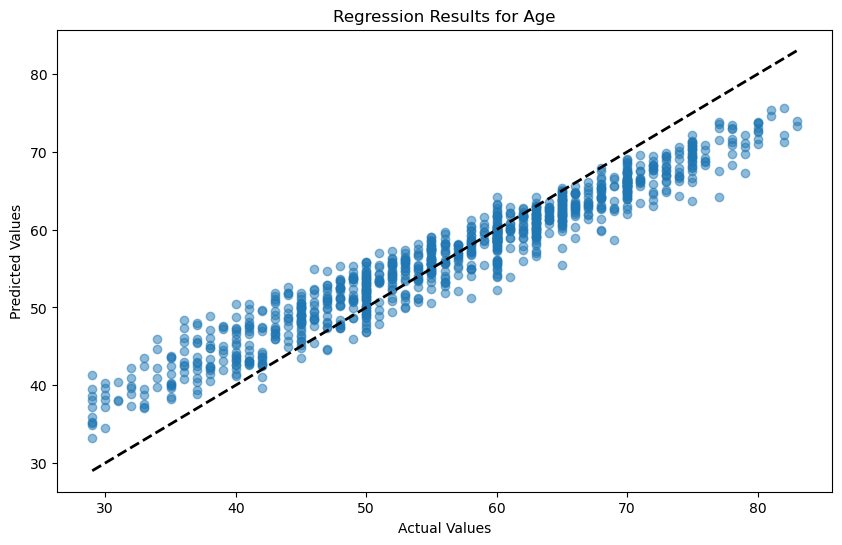

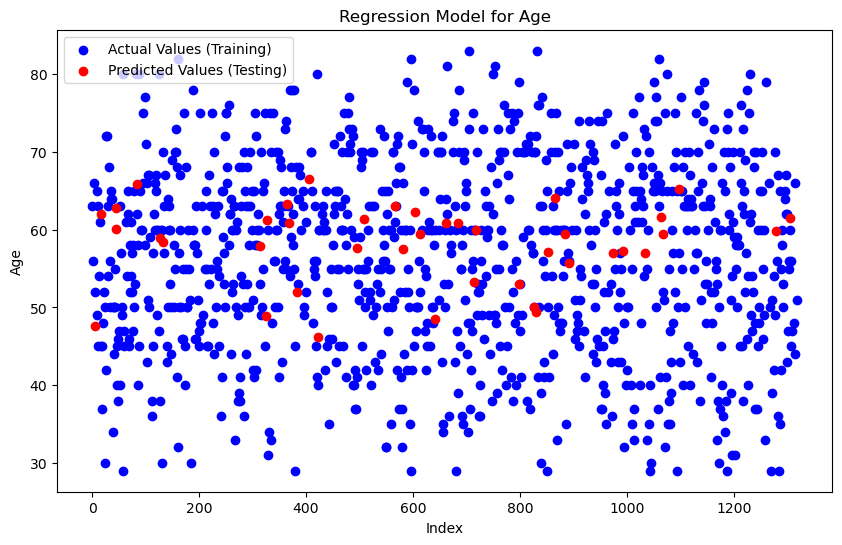

Metrics for Age:
R^2 Score: 0.8683932869334283
Mean Absolute Error: 3.504087870105062
Mean Squared Error: 18.711076790830944




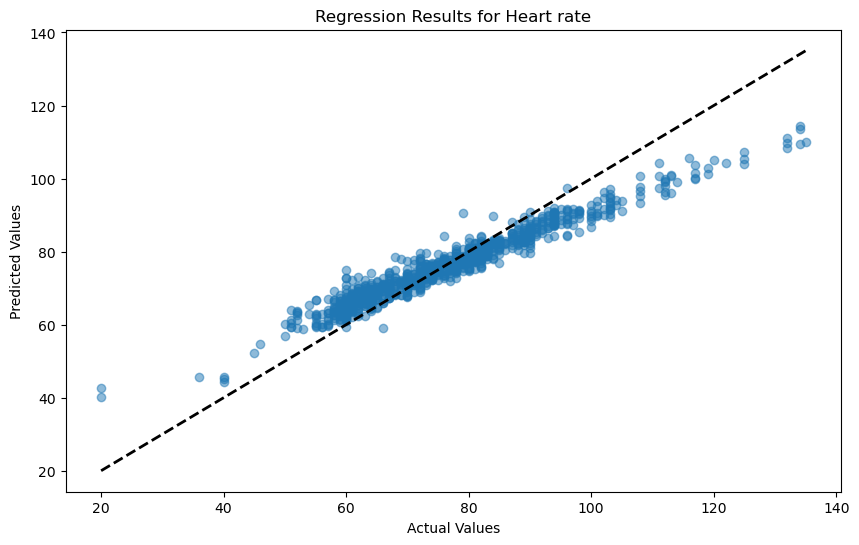

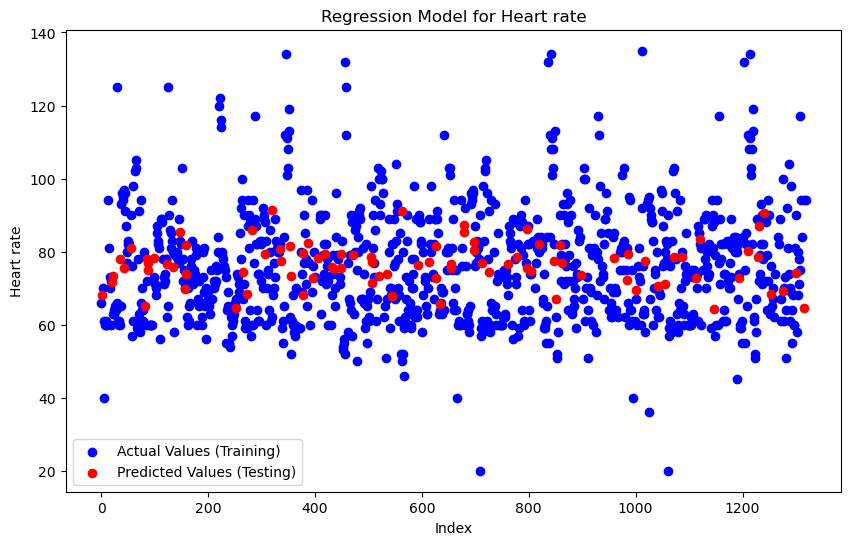

Metrics for Heart rate:
R^2 Score: 0.8563662064002547
Mean Absolute Error: 4.432695390781563
Mean Squared Error: 33.28573196392785




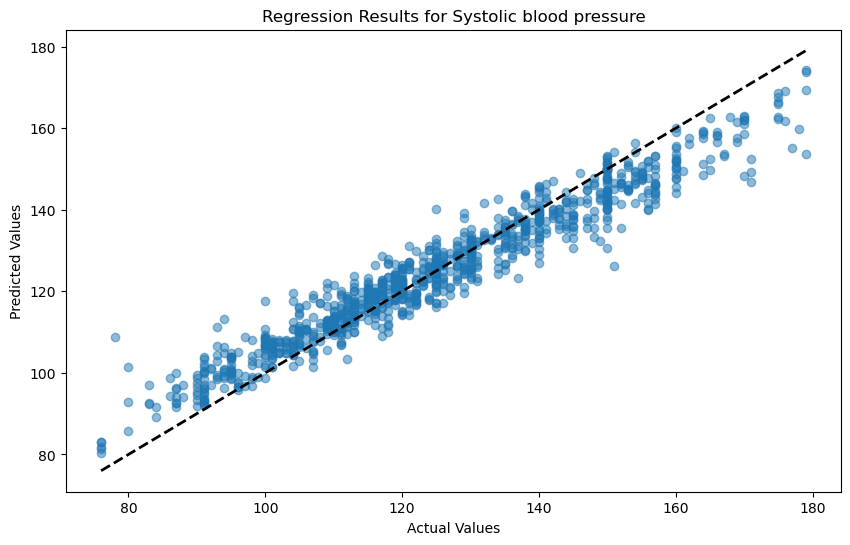

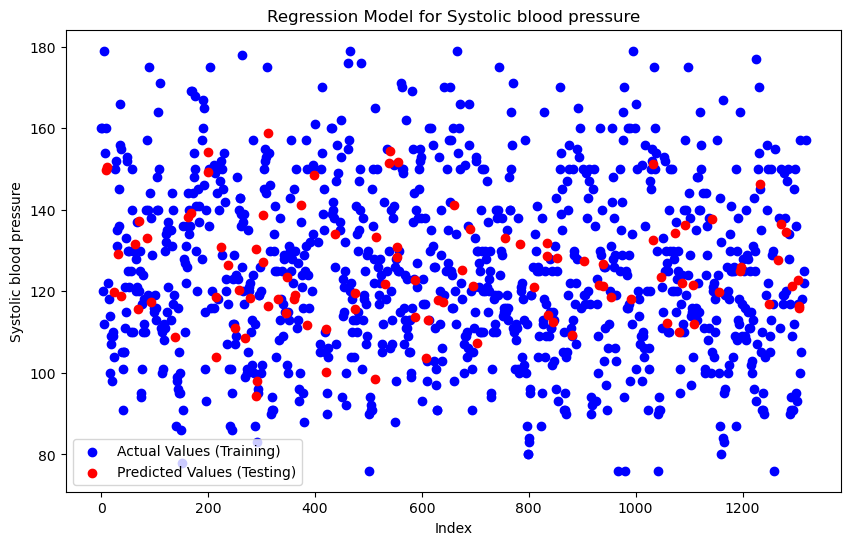

Metrics for Systolic blood pressure:
R^2 Score: 0.9096260645830492
Mean Absolute Error: 4.9455566801619435
Mean Squared Error: 40.80601123481781




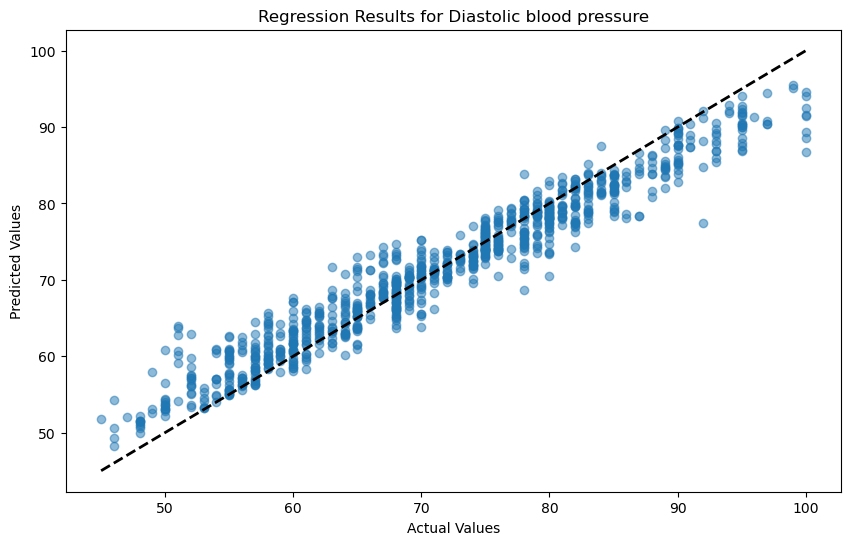

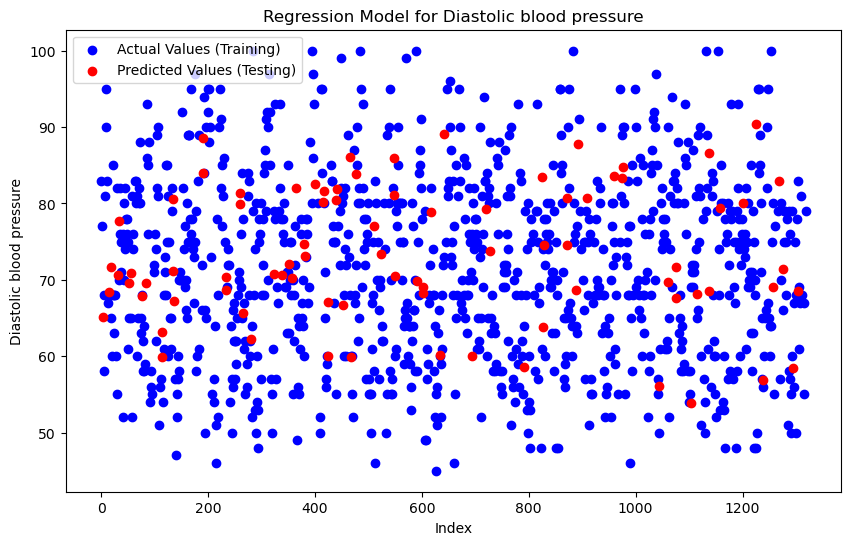

Metrics for Diastolic blood pressure:
R^2 Score: 0.9219469323637131
Mean Absolute Error: 2.5012238805970144
Mean Squared Error: 11.031381990049752




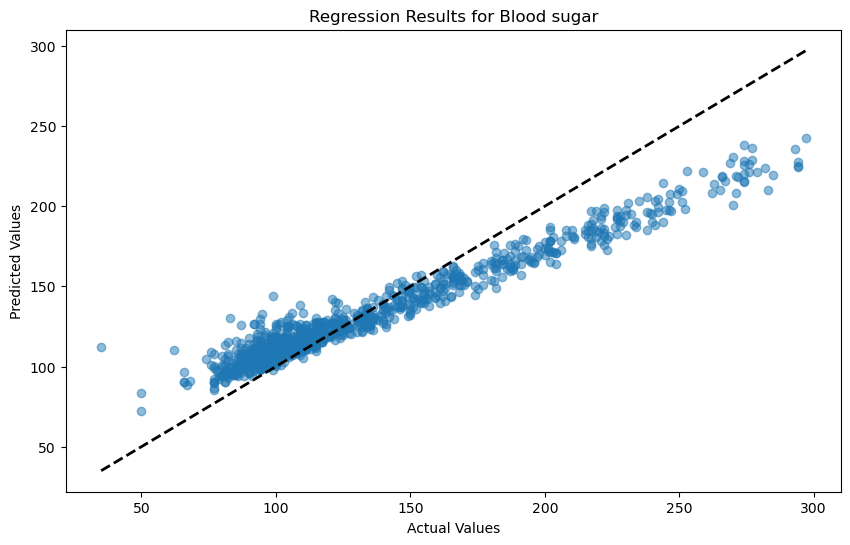

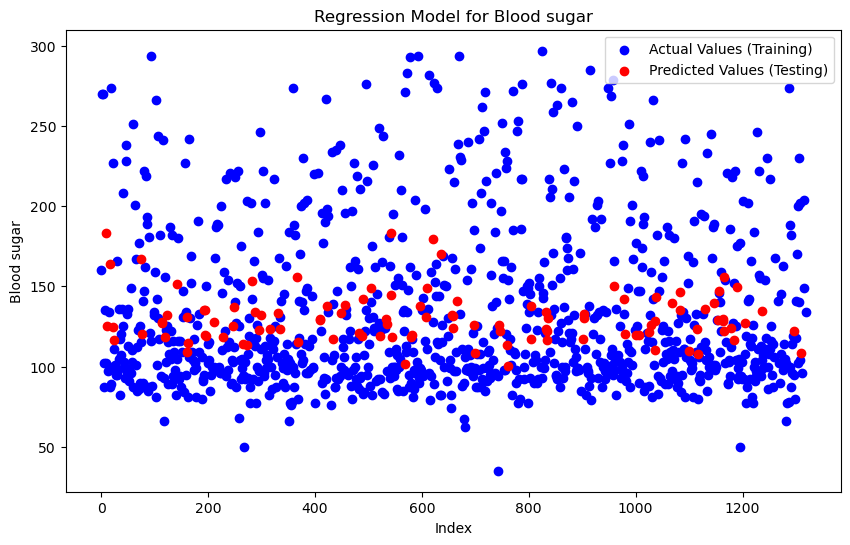

Metrics for Blood sugar:
R^2 Score: 0.8409456832447195
Mean Absolute Error: 15.186077630234934
Mean Squared Error: 402.9314917773238




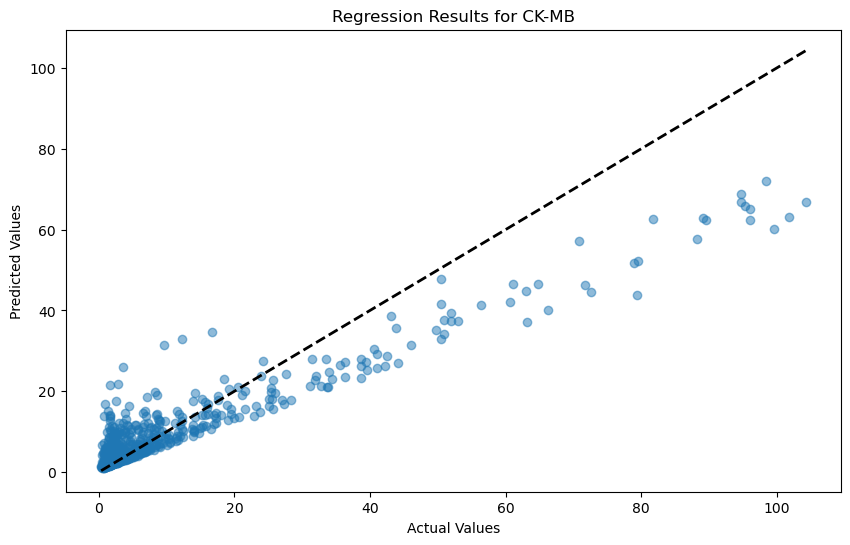

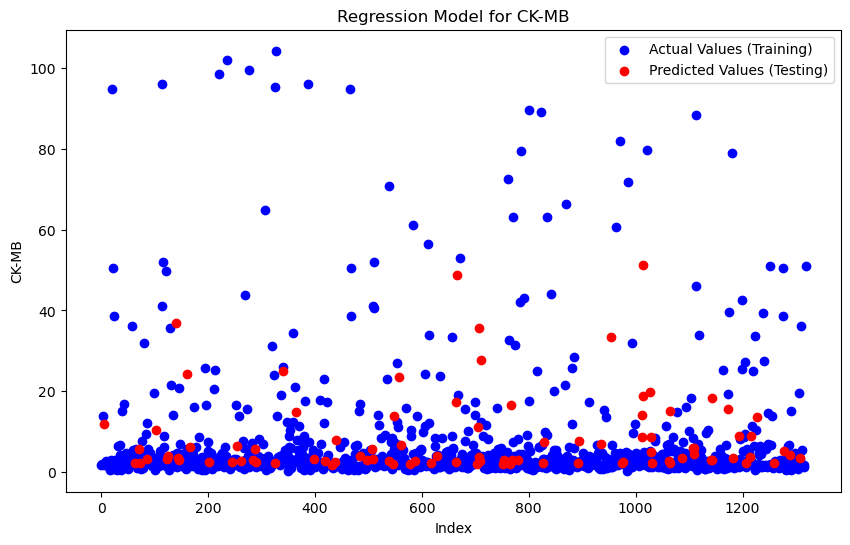

Metrics for CK-MB:
R^2 Score: 0.8415876346001636
Mean Absolute Error: 2.738007394366197
Mean Squared Error: 35.17263896646207


0       0
2       0
3       1
5       0
6       0
       ..
1309    1
1312    0
1314    1
1315    1
1318    1
Name: Result, Length: 1088, dtype: int32
Best Hyperparameters: {'classifier__max_depth': 8, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 10, 'selector__k': 5}
Best Cross-validation Accuracy: 0.9273834185938359
Number of Selected Features: 5
Selected Features: ['Age', 'Gender', 'Systolic blood pressure', 'CK-MB', 'Troponin']
Best Decision Tree Confusion Matrix:
[[361   3]
 [ 54 670]]

Best Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       364
           1       1.00      0.93      0.96       724

    accuracy                           0.95      1088
   macro avg       0.93      0.96      0.94      1088
weighted avg       0.95      0.95      0.9

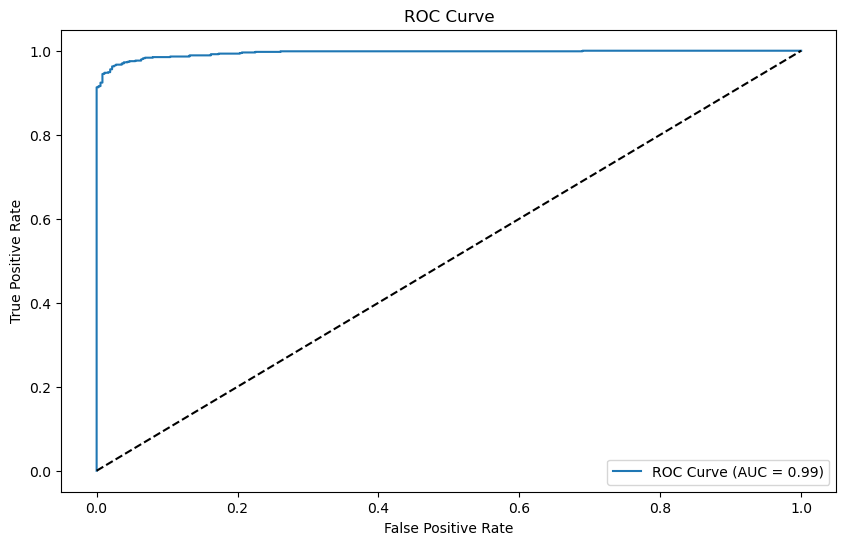

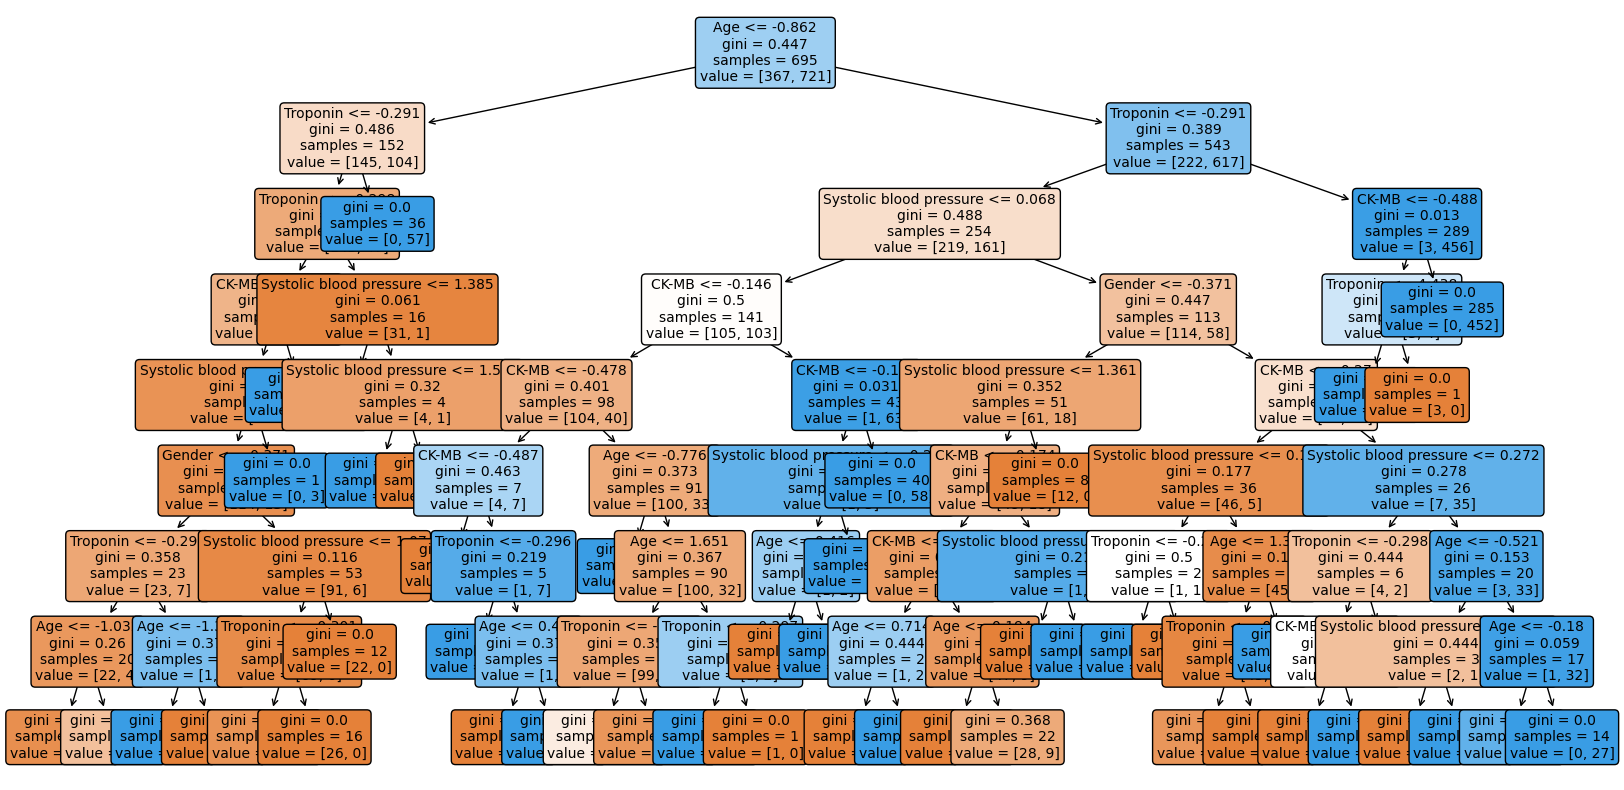

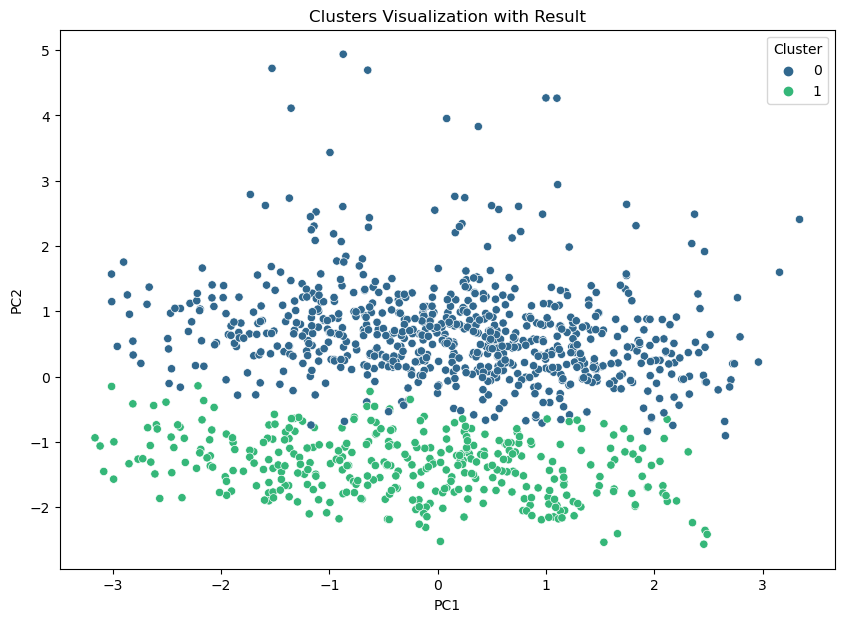

> Cluster Characteristics:
               Age   Gender  Heart rate  Systolic blood pressure  \
Cluster                                                            
0        58.463655  0.69931   76.320938               123.937697   
1        52.930826  0.62259   75.433196               126.765592   

         Diastolic blood pressure  Blood sugar      CK-MB  Troponin    Result  
Cluster                                                                        
0                       71.390593   131.748026  10.126107  0.492181  0.998621  
1                       71.887466   134.008474   2.664717  0.006496  0.000000  
> Cluster 0 Insights:
  - Age: 58.463655172413795
  - Gender: 0.6993103448275862
  - Heart rate: 76.32093793103448
  - Systolic blood pressure: 123.93769655172414
  - Diastolic blood pressure: 71.39059310344828
  - Blood sugar: 131.74802620689655
  - CK-MB: 10.126107296551723
  - Troponin: 0.4921806896551724
  - Result: 0.9986206896551724

> Cluster 1 Insights:
  - Age: 52.9308

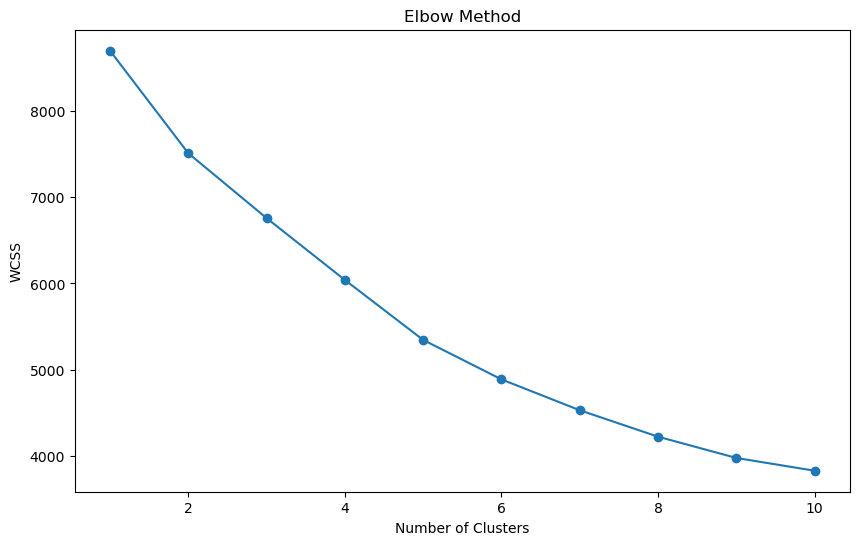

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score, recall_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Step 1: Import the dataset
file_path = r'C:\desktop\자료\Medicaldataset_null.csv'
data = pd.read_csv(file_path)

# Step 2: Data preprocessing
df = pd.DataFrame(data)

# Replace empty strings and spaces with NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Print the 'Result' column before mapping
print("Before mapping:")
print(df['Result'])

# Convert 'Result' column to numerical values
df['Result'] = df['Result'].map({'negative': 0, 'positive': 1})

# Print the 'Result' column after mapping
print("\nAfter mapping:")
print(df['Result'])

# Use KNN Imputer for 'Gender' and 'Result' columns
knn_imputer = KNNImputer(n_neighbors=5)
df[['Gender']] = knn_imputer.fit_transform(df[['Gender']])
df[['Result']] = knn_imputer.fit_transform(df[['Result']])

# Round the imputed values to ensure binary (0 or 1) values and convert to int
df['Gender'] = df['Gender'].round().astype(int)
df['Result'] = df['Result'].round().astype(int)

# Fill 'Troponin' column with mode value
df['Troponin'].fillna(df['Troponin'].mode()[0], inplace=True)

# Function to remove extreme outliers (beyond 2 standard deviations)
def remove_extreme_outliers(df):
    numeric_df = df.select_dtypes(include=[np.number])
    for col in numeric_df.columns:
        mean = numeric_df[col].mean()
        std = numeric_df[col].std()
        df = df[(df[col].isna()) | ((df[col] >= mean - 2 * std) & (df[col] <= mean + 2 * std))]
    return df

# Remove extreme outliers
df = remove_extreme_outliers(df)

# Initialize lists to store performance metrics
r2_scores = []
mae_scores = []
mse_scores = []

# Predict and replace missing values using RandomForestRegressor
for col in df.columns:
    if df[col].isna().sum() > 0:
        temp_df = df.copy()
        temp_df = pd.get_dummies(temp_df, drop_first=True)
        
        # Separate the data into known and unknown parts
        known_data = temp_df[temp_df[col].notna()]
        unknown_data = temp_df[temp_df[col].isna()]
        
        # Separate features and target for known data
        X_train = known_data.drop(col, axis=1)
        y_train = known_data[col]
        
        # Features for unknown data
        X_test = unknown_data.drop(col, axis=1)
        
        # Handle NaN values in the feature columns
        imputer = SimpleImputer(strategy='mean')
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        # Train the RandomForestRegressor model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Predict missing values and store the predictions
        predictions = model.predict(X_test)
        
        # Store indices of missing and non-missing values
        missing_indices = df[df[col].isna()].index
        non_missing_indices = df[df[col].notna()].index
        
        # Replace missing values in the original DataFrame
        df.loc[missing_indices, col] = predictions

        # Calculate metrics for the regression model
        r2 = r2_score(y_train, model.predict(X_train))
        mae = mean_absolute_error(y_train, model.predict(X_train))
        mse = mean_squared_error(y_train, model.predict(X_train))
        
        r2_scores.append((col, r2))
        mae_scores.append((col, mae))
        mse_scores.append((col, mse))

        # Visualize the regression results for each column with missing values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, model.predict(X_train), alpha=0.5)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Regression Results for {col}')
        plt.show()

        # Visualize the actual vs predicted values for each column
        plt.figure(figsize=(10, 6))
        plt.scatter(non_missing_indices, y_train, color='blue', label='Actual Values (Training)')
        plt.scatter(missing_indices, predictions, color='red', label='Predicted Values (Testing)')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.title(f'Regression Model for {col}')
        plt.legend()
        plt.show()

        # Display regression metrics
        print(f"Metrics for {col}:")
        print(f"R^2 Score: {r2}")
        print(f"Mean Absolute Error: {mae}")
        print(f"Mean Squared Error: {mse}")
        print("\n")

# Display the DataFrame after imputation
print(df['Result'])

data = df

# Step 3: Prepare the data for classification
X = data.drop('Result', axis=1)
y = data['Result']

# Step 4: Create a pipeline for classification with feature selection
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid for GridSearchCV
param_grid = {
    'selector__k': [5, 6, 7, 'all'],  # Number of features to select
    'classifier__n_estimators': [5, 10, 15],
    'classifier__max_depth': [None, 4, 6, 8],
    'classifier__min_samples_split': [2, 5, 7]
}

# KFold setting for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with KFold
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

# Perform GridSearchCV
grid_search.fit(X, y)

# Output the best hyperparameters and performance
print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Best Cross-validation Accuracy: {grid_search.best_score_}')

# Step 5: Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
y_pred_proba = best_model.predict_proba(X)[:, 1]

# Calculate metrics
f1 = f1_score(y, y_pred)
recall = recall_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred_proba)
conf_matrix = confusion_matrix(y, y_pred)
class_report = classification_report(y, y_pred)

# Print selected features
selected_features = best_model.named_steps['selector'].get_support(indices=True)
selected_feature_names = X.columns[selected_features]
print(f'Number of Selected Features: {len(selected_feature_names)}')
print(f'Selected Features: {selected_feature_names.tolist()}')

print(f'Best Decision Tree Confusion Matrix:\n{conf_matrix}')
print(f'\nBest Decision Tree Classification Report:\n{class_report}')
print(f'Accuracy: {grid_search.best_score_}')

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Step 6: Visualize the Random Forest tree structure and print it
def visualize_tree(estimator, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(estimator, feature_names=feature_names.tolist(), filled=True, rounded=True, fontsize=10)
    plt.show()

# Visualize the first tree in the Random Forest
best_model = grid_search.best_estimator_.named_steps['classifier']
visualize_tree(best_model.estimators_[0], feature_names=selected_feature_names)

# Step 7: Perform K-means Clustering including the 'Result' column
def perform_kmeans_with_result(X, y, n_clusters):
    X_with_result = np.hstack((X, y.reshape(-1, 1)))  # Append 'Result' column to the features
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_with_result)
    labels = kmeans.labels_
    return labels, kmeans

# Prepare the data by scaling including the 'Result' column
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Result', axis=1).astype(float))
y_scaled = scaler.fit_transform(df[['Result']].astype(float))

# Combine the scaled features and the scaled 'Result' column
data_scaled = np.hstack((X_scaled, y_scaled))

n_clusters = 2  # Number of clusters
kmeans_labels, kmeans_model = perform_kmeans_with_result(X_scaled, y_scaled, n_clusters)

# Add cluster labels to the original data
df['Cluster'] = kmeans_labels

# Step 8: Visualize the Clusters
def visualize_clusters_with_result(X, labels):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = labels

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
    plt.title('Clusters Visualization with Result')
    plt.show()

visualize_clusters_with_result(data_scaled, kmeans_labels)

# Step 9: Analyze cluster characteristics
def analyze_clusters(data, cluster_labels):
    data_with_clusters = data.copy()
    data_with_clusters['Cluster'] = cluster_labels
    
    # Ensure all columns are numeric before calculating mean
    for col in data_with_clusters.columns:
        data_with_clusters[col] = pd.to_numeric(data_with_clusters[col], errors='coerce')

    cluster_summary = data_with_clusters.groupby('Cluster').mean()
    return cluster_summary

# Call the modified analysis function
cluster_summary = analyze_clusters(df, df['Cluster'])
print("> Cluster Characteristics:")
print(cluster_summary)

# Step 10: Interpret and gain insights from clusters
def interpret_clusters(cluster_summary):
    insights = {}
    for cluster in cluster_summary.index:
        insights[cluster] = {}
        for feature in cluster_summary.columns:
            insights[cluster][feature] = cluster_summary.loc[cluster, feature]
    return insights

# Print insights for each cluster
cluster_insights = interpret_clusters(cluster_summary)
for cluster, features in cluster_insights.items():
    print(f"> Cluster {cluster} Insights:")
    for feature, value in features.items():
        print(f"  - {feature}: {value}")
    print()

# Evaluate clustering performance
sil_score = silhouette_score(X_scaled, kmeans_labels)
db_score = davies_bouldin_score(X_scaled, kmeans_labels)

print(f'Silhouette Score: {sil_score}')
print(f'Davies-Bouldin Index: {db_score}')

# Elbow method to find optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init = 10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


Top 5 Model Combinations:
Model: RandomForest
Score: 0.8456136642286392
Params: {'classifier__max_depth': 8, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 15}

Model: LogisticRegression
Score: 0.843816851984949
Params: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Model: SVC
Score: 0.8309305373525557
Params: {'classifier__C': 10, 'classifier__kernel': 'rbf'}

Model: DecisionTree
Score: 0.8208049718851731
Params: {'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__min_samples_split': 7}

Model: KNeighbors
Score: 0.8134697501374033
Params: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}

Best Model: RandomForest
Best Hyperparameters: {'classifier__max_depth': 8, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 15}
Number of Selected Features: 10
Selected Features: ['Age', 'CK-MB', 'Troponin_0.003', 'Troponin_0.004', 'Troponin_0.005', 'Troponin_0.006', 'Troponin_0.007', 'Tropo

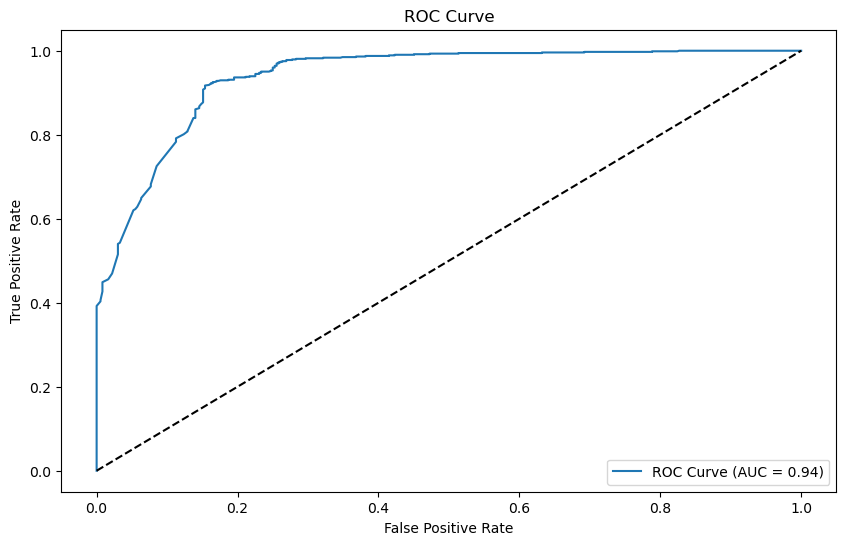

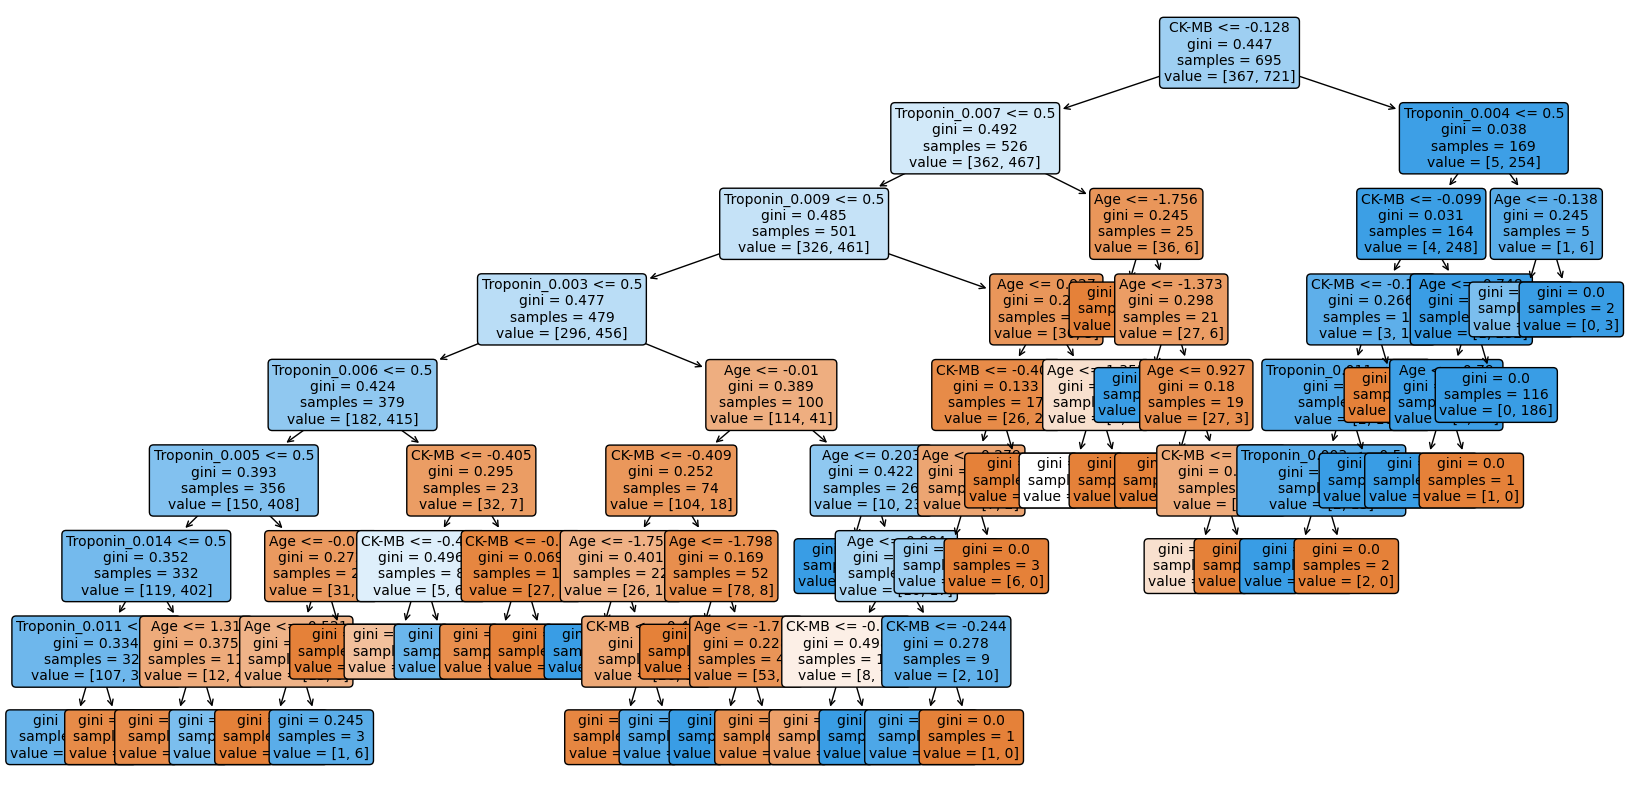

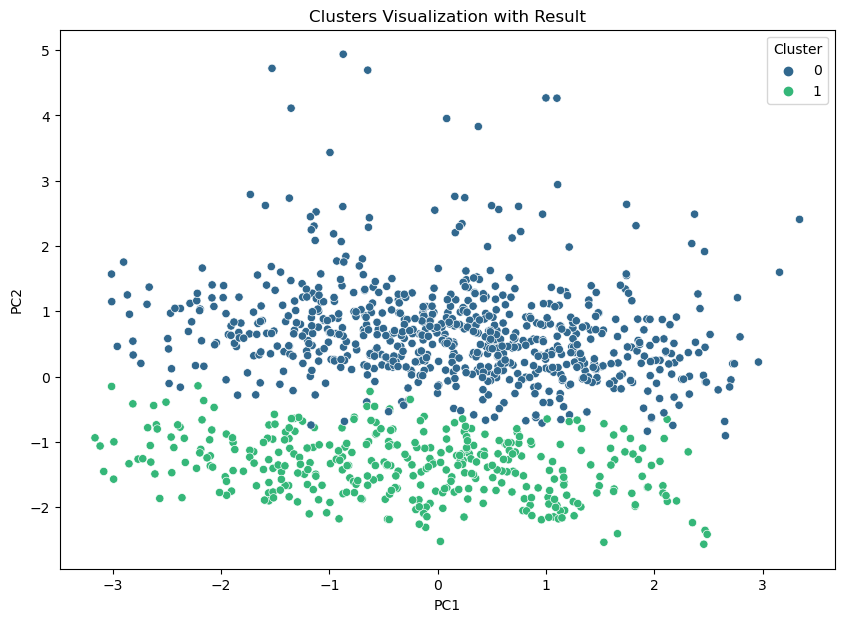

> Cluster Characteristics:
               Age   Gender  Heart rate  Systolic blood pressure  \
Cluster                                                            
0        58.463655  0.69931   76.320938               123.937697   
1        52.930826  0.62259   75.433196               126.765592   

         Diastolic blood pressure  Blood sugar      CK-MB  Troponin    Result  
Cluster                                                                        
0                       71.390593   131.748026  10.126107  0.492181  0.998621  
1                       71.887466   134.008474   2.664717  0.006496  0.000000  
> Cluster 0 Insights:
  - Age: 58.463655172413795
  - Gender: 0.6993103448275862
  - Heart rate: 76.32093793103448
  - Systolic blood pressure: 123.93769655172414
  - Diastolic blood pressure: 71.39059310344828
  - Blood sugar: 131.74802620689655
  - CK-MB: 10.126107296551723
  - Troponin: 0.4921806896551724
  - Result: 0.9986206896551724

> Cluster 1 Insights:
  - Age: 52.9308

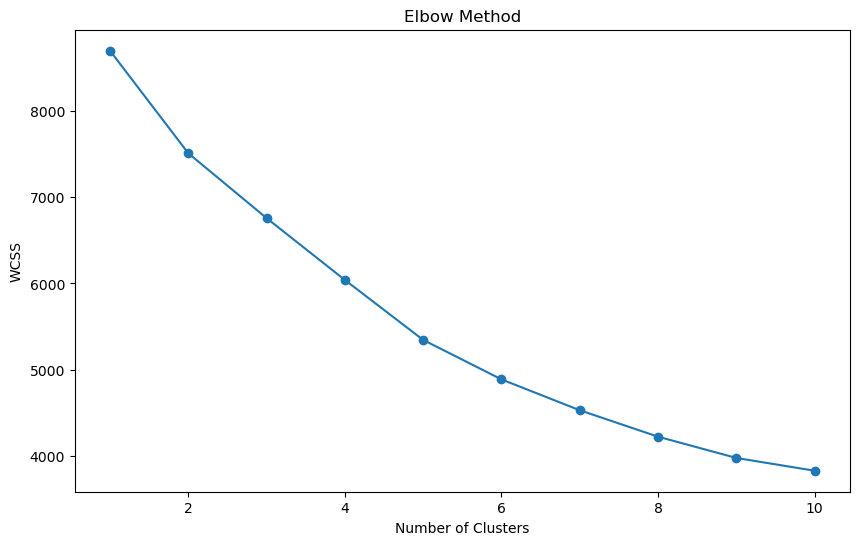

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

def preprocess_and_train_model(file_path):
    # Step 1: Import the dataset
    data = pd.read_csv(file_path)
    df = pd.DataFrame(data)

    # Step 2: Data preprocessing
    # Replace empty strings with NaN
    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    # Map 'Result' column values to binary (0 for negative, 1 for positive)
    df['Result'] = df['Result'].map({'negative': 0, 'positive': 1})

    # Impute missing values in 'Gender' and 'Result' using KNN imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    df[['Gender']] = knn_imputer.fit_transform(df[['Gender']])
    df[['Result']] = knn_imputer.fit_transform(df[['Result']])
    df['Gender'] = df['Gender'].round().astype(int)
    df['Result'] = df['Result'].round().astype(int)
    # Fill missing 'Troponin' values with mode
    df['Troponin'].fillna(df['Troponin'].mode()[0], inplace=True)

    # Function to remove extreme outliers
    def remove_extreme_outliers(df):
        numeric_df = df.select_dtypes(include=[np.number])
        for col in numeric_df.columns:
            mean = numeric_df[col].mean()
            std = numeric_df[col].std()
            df = df[(df[col].isna()) | ((df[col] >= mean - 2 * std) & (df[col] <= mean + 2 * std))]
        return df

    df = remove_extreme_outliers(df)

    r2_scores = []
    mae_scores = []
    mse_scores = []

    # Impute missing values in other columns using RandomForestRegressor
    for col in df.columns:
        if df[col].isna().sum() > 0:
            temp_df = df.copy()
            temp_df = pd.get_dummies(temp_df, drop_first=True)
            known_data = temp_df[temp_df[col].notna()]
            unknown_data = temp_df[temp_df[col].isna()]
            X_train = known_data.drop(col, axis=1)
            y_train = known_data[col]
            X_test = unknown_data.drop(col, axis=1)
            imputer = SimpleImputer(strategy='mean')
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            missing_indices = df[df[col].isna()].index
            df.loc[missing_indices, col] = predictions
            r2_scores.append((col, r2_score(y_train, model.predict(X_train))))
            mae_scores.append((col, mean_absolute_error(y_train, model.predict(X_train))))
            mse_scores.append((col, mean_squared_error(y_train, model.predict(X_train))))

    # Define features and target variable
    data = df
    X = data.drop('Result', axis=1)
    y = data['Result']

    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    # Define column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Define models
    models = [
        ('RandomForest', RandomForestClassifier(random_state=42)),
        ('DecisionTree', DecisionTreeClassifier(random_state=42)),
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVC', SVC(probability=True, random_state=42)),
        ('KNeighbors', KNeighborsClassifier())
    ]

    # Define parameter grids for GridSearchCV
    param_grids = {
        'RandomForest': {
            'classifier__n_estimators': [5, 10, 15],
            'classifier__max_depth': [None, 4, 6, 8],
            'classifier__min_samples_split': [2, 5, 7]
        },
        'DecisionTree': {
            'classifier__max_depth': [None, 4, 6, 8],
            'classifier__min_samples_split': [2, 5, 7],
            'classifier__criterion': ['gini', 'entropy']
        },
        'LogisticRegression': [
            {'classifier__penalty': ['l1'], 'classifier__C': [0.01, 0.1, 1, 10], 'classifier__solver': ['liblinear']},
            {'classifier__penalty': ['l2'], 'classifier__C': [0.01, 0.1, 1, 10], 'classifier__solver': ['lbfgs', 'liblinear']},
            {'classifier__penalty': ['elasticnet'], 'classifier__C': [0.01, 0.1, 1, 10], 'classifier__solver': ['saga'], 'classifier__l1_ratio': [0.5, 0.7, 0.9]},
            {'classifier__penalty': ['none'], 'classifier__solver': ['lbfgs']}
        ],
        'SVC': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf', 'poly']
        },
        'KNeighbors': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    }

    best_models = []

    # Train and evaluate models using GridSearchCV
    for name, model in models:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('selector', SelectKBest(f_classif)),
            ('classifier', model)
        ])

        param_grid = param_grids[name]
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')
        grid_search.fit(X, y)

        best_models.append((grid_search.best_score_, name, grid_search.best_params_, grid_search.best_estimator_))

    best_models.sort(reverse=True, key=lambda x: x[0])

    # Print top 5 models
    print("Top 5 Model Combinations:")
    for score, name, params, model in best_models[:5]:
        print(f"Model: {name}")
        print(f"Score: {score}")
        print(f"Params: {params}")
        print()

    best_model = best_models[0][3]
    y_pred = best_model.predict(X)
    y_pred_proba = best_model.predict_proba(X)[:, 1]

    f1 = f1_score(y, y_pred)
    recall = recall_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    conf_matrix = confusion_matrix(y, y_pred)
    class_report = classification_report(y, y_pred)

    # Get feature names after one hot encoding
    preprocessor.fit(X)
    encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = np.hstack([numeric_features, encoded_feature_names])

    selected_features = best_model.named_steps['selector'].get_support(indices=True)
    selected_feature_names = all_feature_names[selected_features]

    # Print model details and metrics
    print(f'Best Model: {best_models[0][1]}')
    print(f'Best Hyperparameters: {best_models[0][2]}')
    print(f'Number of Selected Features: {len(selected_feature_names)}')
    print(f'Selected Features: {selected_feature_names.tolist()}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Visualize tree for Decision Tree and Random Forest
    if best_models[0][1] == 'RandomForest':
        plt.figure(figsize=(20, 10))
        plot_tree(best_model.named_steps['classifier'].estimators_[0], feature_names=selected_feature_names.tolist(), filled=True, rounded=True, fontsize=10)
        plt.show()
    elif best_models[0][1] == 'DecisionTree':
        plt.figure(figsize=(20, 10))
        plot_tree(best_model.named_steps['classifier'], feature_names=selected_feature_names.tolist(), filled=True, rounded=True, fontsize=10)
        plt.show()

    # KMeans clustering with result column
    def perform_kmeans_with_result(X, y, n_clusters):
        X_with_result = np.hstack((X, y.reshape(-1, 1)))
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        kmeans.fit(X_with_result)
        return kmeans.labels_, kmeans

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df.drop('Result', axis=1).astype(float))
    y_scaled = scaler.fit_transform(df[['Result']].astype(float))
    data_scaled = np.hstack((X_scaled, y_scaled))

    n_clusters = 2
    kmeans_labels, kmeans_model = perform_kmeans_with_result(X_scaled, y_scaled, n_clusters)
    df['Cluster'] = kmeans_labels

    # Visualize clusters
    def visualize_clusters_with_result(X, labels):
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(X)
        pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
        pca_df['Cluster'] = labels

        plt.figure(figsize=(10, 7))
        sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
        plt.title('Clusters Visualization with Result')
        plt.show()

    visualize_clusters_with_result(data_scaled, kmeans_labels)

    # Analyze cluster characteristics
    def analyze_clusters(data, cluster_labels):
        data_with_clusters = data.copy()
        data_with_clusters['Cluster'] = cluster_labels
        for col in data_with_clusters.columns:
            data_with_clusters[col] = pd.to_numeric(data_with_clusters[col], errors='coerce')
        return data_with_clusters.groupby('Cluster').mean()

    cluster_summary = analyze_clusters(df, df['Cluster'])
    print("> Cluster Characteristics:")
    print(cluster_summary)

    # Interpret cluster insights
    def interpret_clusters(cluster_summary):
        insights = {}
        for cluster in cluster_summary.index:
            insights[cluster] = {}
            for feature in cluster_summary.columns:
                insights[cluster][feature] = cluster_summary.loc[cluster, feature]
        return insights

    cluster_insights = interpret_clusters(cluster_summary)
    for cluster, features in cluster_insights.items():
        print(f"> Cluster {cluster} Insights:")
        for feature, value in features.items():
            print(f"  - {feature}: {value}")
        print()

    # Calculate clustering performance scores
    sil_score = silhouette_score(X_scaled, kmeans_labels)
    db_score = davies_bouldin_score(X_scaled, kmeans_labels)

    print(f'Silhouette Score: {sil_score}')
    print(f'Davies-Bouldin Index: {db_score}')

    # Elbow method to determine optimal number of clusters
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

# Example usage
file_path = r'C:\desktop\자료\Medicaldataset_null.csv'
preprocess_and_train_model(file_path)
